# ORIE 4580/5580/5581 Assignment 3

#### Students: Yik Hau, Au (ya293) and  Dionisius Davido Tjajono (dt565)

### Github link: [example Github link](https://github.com/SidBanerjee/ORIE4580-Simulation/blob/main/Notebooks/Unit0-Intro_Demos.ipynb)

(**Please replace this with your own link!**)

### Instructions


* Due Thursday September 25, at 11.59pm on Gradescope.
* Assignment .ipynb files available for download on [Canvas](https://canvas.cornell.edu/courses/80773#:~:text=Assignments-,Assignments,-Assignments%20module%20publish).
* Do all your work in provided notebook (text answers typeset in markdown; show all required code and generate plots inline), and then generate and submit a pdf.
* Ideally do assignments in groups of 2, and submit a single pdf with both names
* Please show your work and clearly mark your answers.
* You can use any code fragments given in class, found online (for example, on StackOverflow), or generated via Gemini/Claude/ChatGPT (you are encouraged to use these for first drafts) **with proper referencing**.
* You can also discuss with others (again, please reference them if you do so); but you must write your final answers on your own as a team.




### Suggested reading

Chapters 7 (you can skim through this), and chapters 8 and 9 of [Introduction to Probability](https://chance.dartmouth.edu/teaching_aids/books_articles/probability_book/book.html) by Grinstead and Snell.

Chapter 3 and chapter 4 (up to section 4.5) of [Simulation by Ross](https://catalog.library.cornell.edu/catalog/12745977).

In [13]:
#importing necessary packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
%matplotlib inline
# Make sure we have the packages we need
import numpy as np
from scipy import stats
import math

# Configuring matplotlib
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.style.use('dark_background')
plt.rcParams["image.cmap"] = 'Set3'

# Choosing a colormap for the plot colors
cmap=plt.get_cmap('Set3')

<hr><hr>

## Question 1: Combining LCGs (20 points)

In order to avoid biases, simulations should not use anywhere near the full period of an LCG (otherwise, the random sequence repeats \dots). For example, a typical traffic simulator may have $10,000$ vehicles, each experiencing thousands of random disturbances, thus needing around $10^7$ random samples per replication -- for this, an LCG using $m=2^{31}-1\approx 2\times 10^9$ is insufficient, as after $100$ replications the sequences get correlated.

One method to combine multiple LCGs to obtain a generator with a longer period is to add a smaller period LCG to it. For example, suppose we have two generators $X_{n+1}  =  (a_1 X_n) \mbox{ mod } m_1$ and $Y_{n+1}  =  (a_2 Y_n) \mbox{ mod } m_2$, with $m_1>m_2$. We can derive a combined generator by setting $Z_n  =  (X_n + Y_n) \mbox{ mod } m_1$. If properly designed, the resulting period can be on the order of $m_1m_2$. We will now study a small example to see how this works.


<hr>

**(a)** Consider two LCGs, $x_{n+1} = (5 x_n) \mod 16$ and $y_{n+1} = (2 y_n) \mod 7$. Starting both with seed $x_0 = y_0 = 1$, plot the sequences $x_n, y_n$ using the clock visualization introduced in class (separate plot for each sequence; you can use and modify the code in Demo-PRNGs.ipynb on Canvas).

<hr>

In [14]:
# Functions to visualize LCG sequence on clock (see demo notebook)
def plot_clock_face(m, fig, annotate=False):
  """
  Plot points on a unit circle representing the LCG sequence on a clock face.

  Parameters:
  m (int): The modulus value for the LCG sequence.
  fig (matplotlib.figure.Figure): The figure object to draw on.
  annotate (bool): Whether to annotate points with their index.

  Returns:
  None
  """
  # Plot m points on the unit circle
  for i in range(m):
      theta = 2.0 * np.pi * i / m
      plt.plot(np.sin(theta), np.cos(theta), 'rs', markersize = 10)
      if annotate:
          plt.annotate(str(i), (np.pi/2 - theta, 1.05), xycoords='polar')

def plot_clock_path(m, x, fig, color='y'):
  """
  Plot the path of an LCG sequence on a clock face.

  Parameters:
  m (int): The modulus value for the LCG sequence.
  x (numpy.ndarray): The LCG sequence.
  fig (matplotlib.figure.Figure): The figure object to draw on.
  color (str): The color for the path.

  Returns:
  None
  """
  # Plot the seed node
  theta_0 = 2.0 * np.pi * (x[0] * (m + 1) - 1) / m
  plt.plot(np.sin(theta_0), np.cos(theta_0), 'gs', markersize = 10)

  # Plot the path of the LCG sequence
  for i in range(len(x) - 1):
      theta_start = 2.0 * np.pi * (x[i] * (m + 1) - 1) / m
      theta_end = 2.0 * np.pi * (x[i + 1] * (m + 1) - 1) / m
      x_start = np.sin(theta_start)
      y_start = np.cos(theta_start)
      del_x = np.sin(theta_end) - np.sin(theta_start)
      del_y = np.cos(theta_end) - np.cos(theta_start)
      if abs(del_x) > 0 or abs(del_y) > 0:
          plt.arrow(x_start, y_start, del_x, del_y,
                    length_includes_head=True, head_width=0.05, head_length=0.1, fc=color, ec=color)


In [15]:
# Function to generate pseudorandom sequence using LCG
# Set default parameters to glibc specifications (see demo notebook)
def LCG(n, m=2**31-1, a=1103515245, c=12345, seed=1):
    """
    Generate a pseudorandom sequence using a Linear Congruential Generator (LCG).

    Parameters:
    n (int): The number of pseudorandom numbers to generate.
    m (int): The modulus value (default is 2^31-1, following glibc specifications).
    a (int): The multiplier value (default is 1103515245, following glibc specifications).
    c (int): The increment value (default is 12345, following glibc specifications).
    seed (int): The initial seed value (default is 1).

    Returns:
    numpy.ndarray: An array of pseudorandom numbers in the range [0, 1).
    """
    # Initialize an array to store the generated pseudorandom numbers
    output = np.zeros(n)

    x = seed
    for i in range(n):
        # Calculate the pseudorandom number and normalize it to [0, 1)
        output[i] = (x + 1.0) / (m + 1.0)

        # Update the LCG state using the specified parameters
        x = (a * x + c) % m

    return output


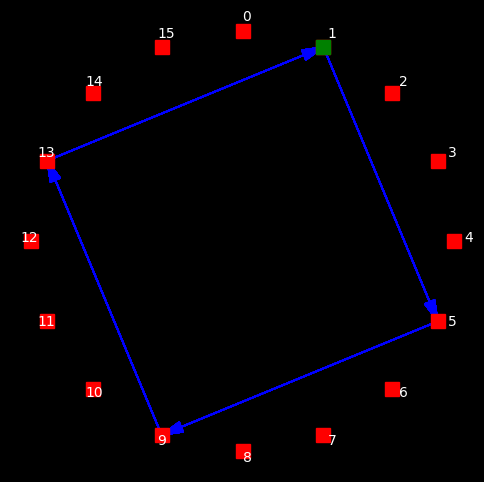

In [16]:
#LCG 1
m1 = 16
m2 = 7
a1 = 5
c1 = 0
seed = 1

fig = plt.figure(figsize=(6,6))

plot_clock_face(m1,fig,annotate = True)

x = LCG(n=m1*m2,m=m1,a=a1,c=c1,seed=seed)
plot_clock_path(m1,x,fig,color='b')

plt.axis('off')
plt.show()

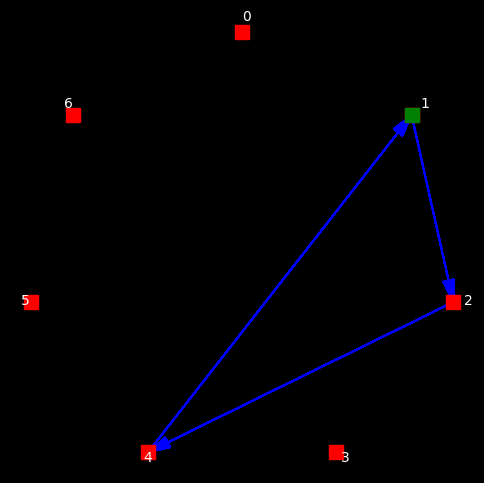

In [17]:
#LCG 2
m2 = 7
a2 = 2
c2 = 0
seed = 1

fig = plt.figure(figsize=(6,6))

plot_clock_face(m2,fig,annotate = True)

y = LCG(n=m2*m1,m=m2,a=a2,c=c2,seed=seed)
plot_clock_path(m2,y,fig,color='b')

plt.axis('off')
plt.show()

<hr>

**(b)** Next, define a combined LCG as $z_{n} = (x_n+y_n) \mod 16$. Starting both the base LCGs with seed $x_0 = y_0 = 1$, plot the sequence $z_n$ using the clock visualization given in class.

<hr>

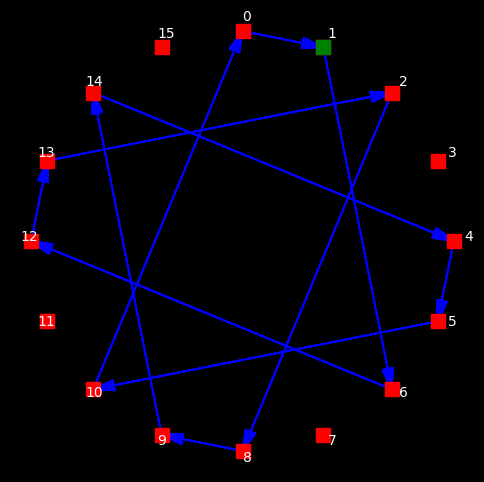

In [18]:
#LCG Z
m3 = 16
c2 = 0
seed = 1

fig = plt.figure(figsize=(6,6))

plot_clock_face(m3,fig,annotate = True)

# Revert the U back to x and y
xx = (x * (m1 + 1.0) - 1).astype(int)
yy = (y * (m2 + 1.0) - 1).astype(int)
z = (xx+yy)%16

plot_clock_path(m3,z,fig,color='b')

plt.axis('off')
plt.show()

___
**(c)** What are the periods of the pseudo-random sequences $x_n, y_n$ and $z_n$?
___

### Ans.


##### Assume the starting seed is 1,

In [19]:
print(f"The pseudo-random sequences for Xn is {len(set(x))}")
print(f"The pseudo-random sequences for yn is {len(set(y))}")
print(f"The pseudo-random sequences for zn is {len(set(z))}")

The pseudo-random sequences for Xn is 4
The pseudo-random sequences for yn is 3
The pseudo-random sequences for zn is 12


___
___
## Question 2: inverting cdfs (25 pts)

In class, we defined $F^{-1}(y)$ for a continuous increasing cdf $F(x)$ as the unique $x$ such that $F(x) = y$ (for $y\in[0,1]$). More generally, for any cdf $F$ we can use the inversion method based on its generalized inverse or *pseudoinverse*:
	$$F^{-1}(y) = \inf\{x|F(x)\geq y\}$$
	(where $\inf$ denotes the \href{https://en.wikipedia.org/wiki/Infimum_and_supremum}{infimum}; if you have not seen this before, treat it as minimum).


___
**(a)** Find the pseudoinverse $F^{-1}(y)$ for the following mixed (discrete/continuous) cdf
	$$F(x)=
	\begin{cases}
	0 & \mbox{for $x < 0$}\\
	x & \mbox{for $0 \leq x < \frac{1}{2}$}, \\
	\frac{1}{2} & \mbox{for $\frac{1}{2}\leq x < 1$}, \\
	1 & \mbox{for $x\geq 1$}
	 \end{cases}$$
___

### Ans.


$$
F^-1(u)=
	  \begin{cases}
	u & \mbox{for $0 \leq u \leq \frac{1}{2}$}, \\
	1 & \mbox{for $\frac{1}{2} < u \leq 1$}
	  \end{cases}
$$

___
**(b)** Use the above definition to get an inversion algorithm for the $Geometric(p)$ distribution (with pmf $p(k) = p(1-p)^{k-1}\,\forall\,k\in\{1,2,3,\ldots\}$). Implement this, and generate and plot the histogram of 1000 samples from a $Geometric(0.42)$ distribution.
(For this, it may be useful for you to first understand how the [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html) library works, and in particular, how it provides methods to compute various statistics for many different random variables, including the [geometric r.v.](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.geom.html#scipy.stats.geom))
___

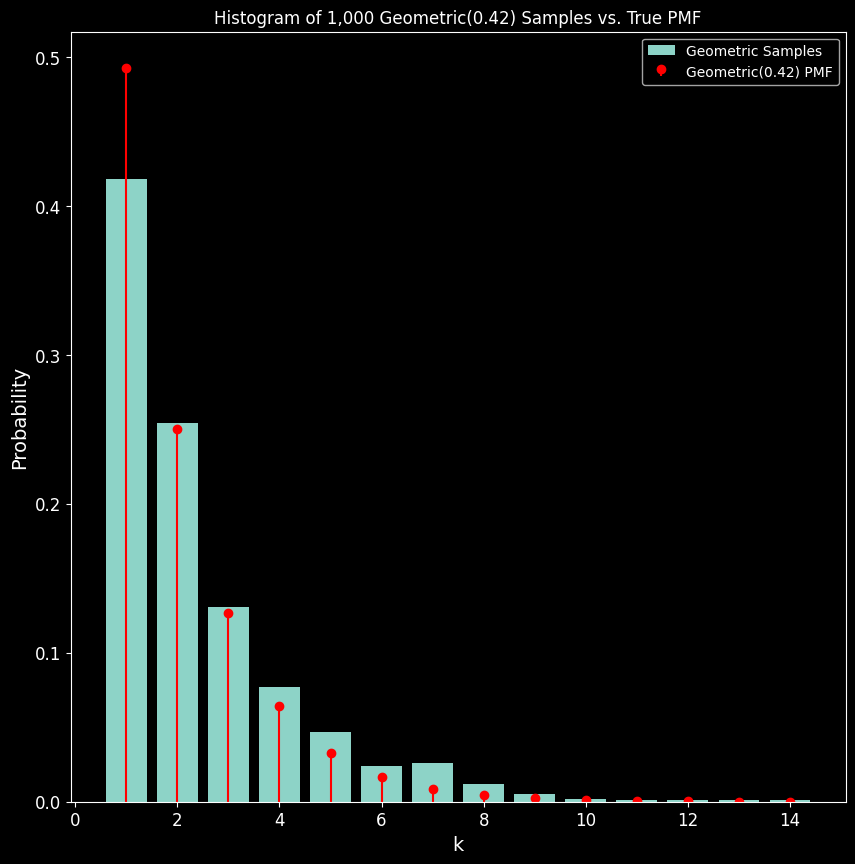

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sc

n = 1000
u = np.random.uniform(0,1,n)

geo = scipy.stats.geom.isf(1-u, 0.42)
plt.hist(geo, bins=range(1, int(max(geo))+2), density=True, label='Geometric Samples', align='left', rwidth=0.8)
k = np.arange(1, int(max(geo)) + 1)
geo_pmf = sc.geom.pmf(k, p)
plt.stem(k, geo_pmf, 'r-', label='Geometric(0.42) PMF', basefmt=" ")
plt.title('Histogram of 1,000 Geometric(0.42) Samples vs. True PMF')
plt.xlabel('k')
plt.ylabel('Probability')
plt.legend()
plt.show()

___
**(c)** The p.d.f. of the random variable $X$ is given by
	$$
	f(x) =
	\begin{cases}
		e^{x-2} & \text{for }0 \leq x \leq 2, \\
		e^{-x} & \text{for }x > 2, \\
		0 & \text{otherwise,}
	\end{cases}
	$$
	Describe and implement an inversion algorithm to generate samples of $X$. Generate 1,000 samples and plot a histogram. Compare the histogram and the p.d.f.


___

### Ans.

$$
F(x) =
\begin{cases}
0 & x < 0 \\
e^{x-2}-e^{-2} & 0 \leq x \leq 2\\
-e^{-x}+1 & x > 2 \\
\end{cases}
$$
$$
F^{-1}(u) =
\begin{cases}
ln(ue^{2}+1) & 0 \leq u \leq 1-e^{-2}\\
-ln(1-u) & u > 1-e^{-2} \\
\end{cases}
$$


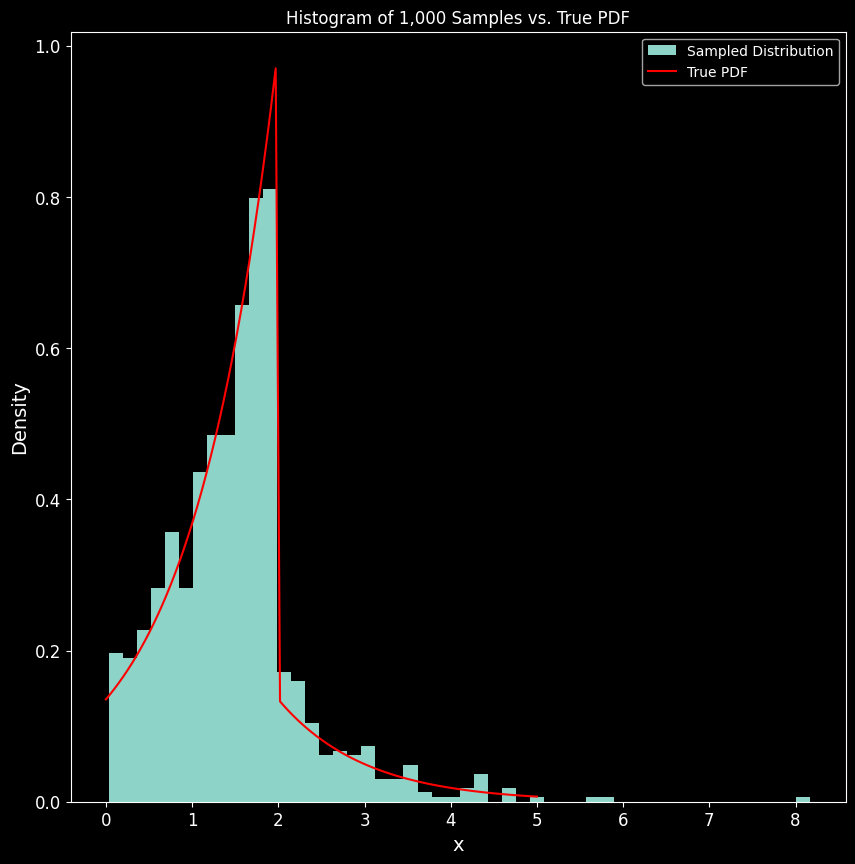

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sc
import math

np.random.seed(42)
n = 1000
u = np.random.uniform(0,1,n)

plt.hist(np.where(u<1-math.e**(-2),np.log(u*np.e**2+1), -np.log(1-u)),bins=50, density=True,label='Sampled Distribution')
x_range = np.linspace(0, 5, 100)
pdf = np.where(x_range <= 2, np.exp(x_range - 2), np.exp(-x_range))
plt.plot(x_range, pdf, 'r-', label='True PDF')
plt.title('Histogram of 1,000 Samples vs. True PDF')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.show()

<hr><hr>

## Question 3: Acceptance-Rejection (25 pts)

Let the random variable $X$ have density
$$f(x) = \begin{cases} (5 x^4 + 4x^3 + 3x^2+1)/4  & \text{ for } 0 \leq x \leq 1, \\
0 & \text{ otherwise. } \end{cases}$$

<hr>

**(a)** Give an acceptance-rejection algorithm to generate samples of
	$X$.

<hr>

### Ans.


1. Generate (U,V) with $U \sim Unif(0,1) \text{ and } V \sim Unif(0,M)$ for some M that is the an upper bound of the maximum of f(x)
2. Accept X = U if $V \leq f(U)$. Reject and repeat step 1 otherwise

In [26]:
rand_u = np.random.uniform(0,1)
M = 13.0/4 # the maximum value from f(x) in interval [0, 1]
rand_v = np.random.uniform(0,M)
prob_accept = (5*(rand_u**4)+4*(rand_u**3)+3*(rand_u**2)+1)/4
if (rand_v <= prob_accept):
  acc = True
else:
  acc = False
print(acc)

False


<hr>

**(b)** On average, how many samples from the uniform distribution over $[0, 1]$ would your acceptance-rejection algorithm need in order to generate one sample of $X$?

<hr>

### Ans.


By calculus, we know the maximum of f(x) is 13/4 for $0 \leq x \leq 1$, thus we set M = 13/4. The distribution of sample needed to get one sample is geo(1/M), thus the average is $M=3.25$ samples.

<hr>

**(c)** Use your algorithm in (a) to generate 2,500 samples of $X$. Note that this will require more than 2500 uniform random variables.

Plot a histogram of your sample   and compare it against the true pdf.

<hr>

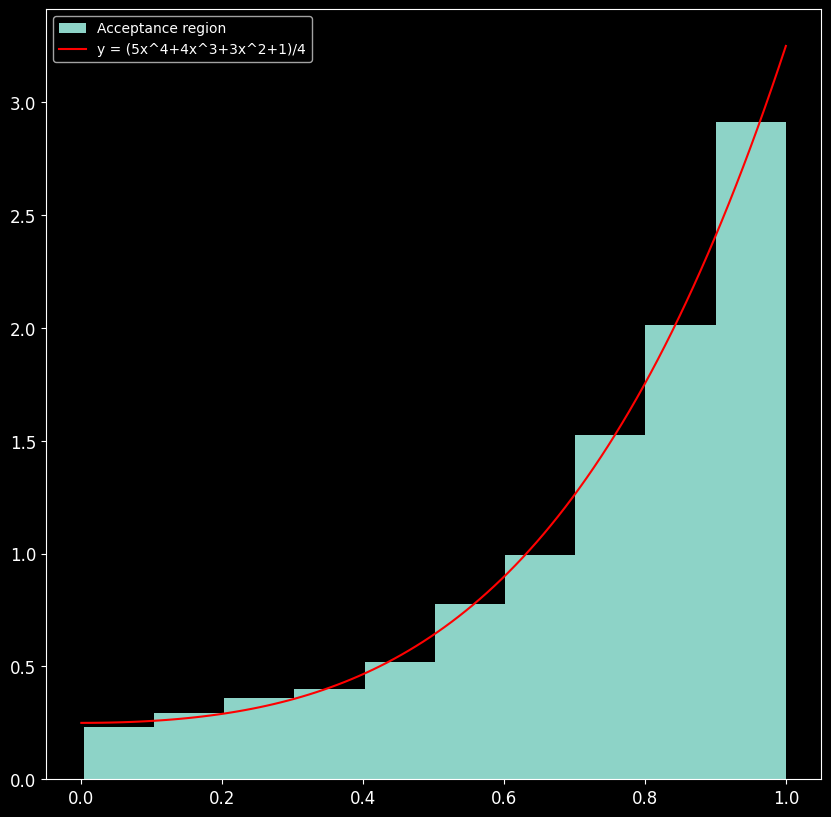

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import math

n = 2500
x = np.zeros(n)
i = 0

def f(x):
  return (5*x**4+4*x**3+3*x**2+1)/4

while i != n:
  u = np.random.uniform(0,1)
  v = np.random.uniform(0,3.25)
  if v <= f(u):
    x[i] = u
    i +=1

x_pt = np.linspace(0,1,100)
y_pt = f(x_pt)

plt.hist(x, density=True, label="Acceptance region")
plt.plot(x_pt, y_pt, "r-", label='y = (5x^4+4x^3+3x^2+1)/4')
plt.legend()
plt.show()

<hr><hr>

## Question 4: Generalized Acceptance-Rejection (30 pts)

We want to generate a $\mathcal{N}(0,1)$ rv $X$, with pdf
$f(x) = \frac{e^{-x^2/2}}{\sqrt{2\pi}} $,
using generalized acceptance-rejection.

<hr>

**(a)** First, suppose we choose the proposal distribution to be a $\emph{Laplace}$ (i.e., two-sided Exponential) distribution, which has pdf $g(x) = e^{-|x|}/2$. Describe (and implement) an inversion algorithm to get samples from this distribution.

<hr>

##### We can sample U from unif(0,1) and plug into $G^-1(u)$ which has the same distribution as g, where G is the CDF
$$
G(x) =
\begin{cases}
e^x/2 & x<0\\
1-e^{-x}/2 & x \geq 0 \\
\end{cases}
$$
$$
G^-1(u) =
\begin{cases}
ln(2u) &u \in [0,1/2)\\
-ln(2-2u) &u \in [1/2,1]\\
\end{cases}
$$

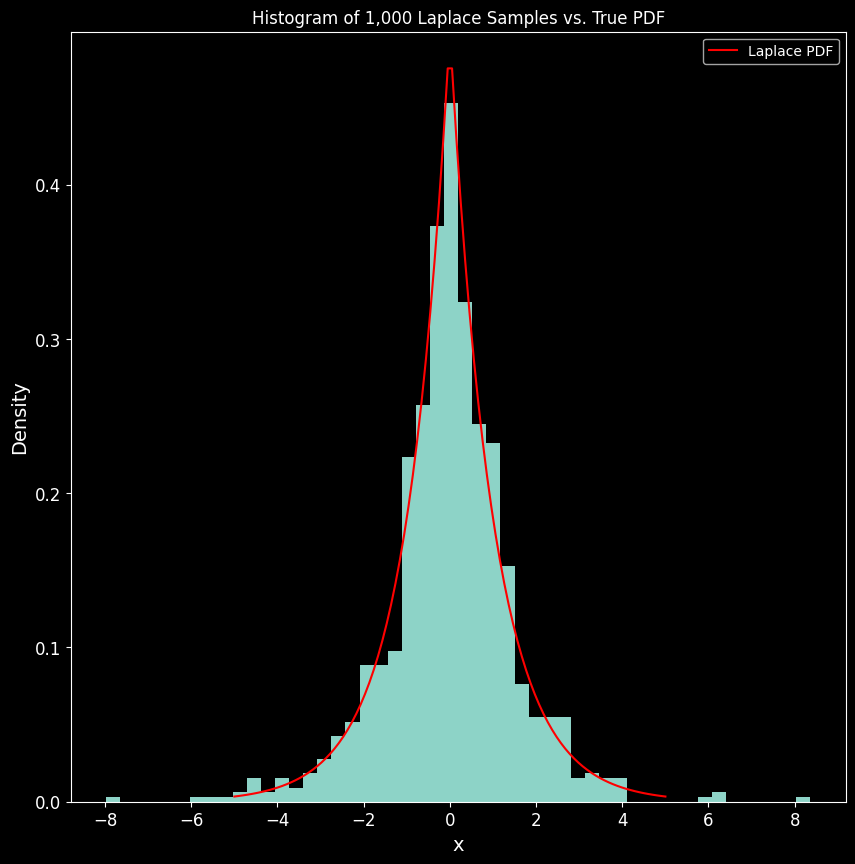

In [34]:
import numpy as np
import math
import matplotlib.pyplot as plt

u = np.random.uniform(0,1, 1000)
G = np.where(u<0.5, np.log(2*u), -np.log(2-2*u))

plt.hist(G, density=True, bins=50)
x = np.linspace(-5, 5, 100)
laplace_pdf = 0.5 * np.exp(-np.abs(x))
plt.plot(x, laplace_pdf, 'r-', label='Laplace PDF')
plt.title('Histogram of 1,000 Laplace Samples vs. True PDF')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.show()

<hr>

**(b)** Determine the smallest $k$ such that $kg(x)\geq f(x)\,\forall\,x\in\mathbb{R}$. Using this, propose (and implement) an acceptance-rejection algorithm for sampling $X\sim\mathcal{N}(0,1)$, and compute the expected number of samples needed for generating each sample.

<hr>

### Ans.

Define $h(x) = f(x)/g(x) = e^{-x^2/2+x}(2/\sqrt{2\pi})$.

Maximum of $h(x)$ occurs at $x=1$ with $h(1) = \sqrt{2e/\pi} = k$. The acceptance-rejection algorithm is:

1.   Generate $U \sim G$
2.   Accept U as a sample from f(U) with probability $\frac{f(U)}{k*g(U)}$. Else, reject $U$ and return to step 1

In [35]:
k = np.sqrt(2*np.e/np.pi)
print(f"The expected sample needed is {k:.3f}")

The expected sample needed is 1.315


<hr>

**(c)** Generate $1000$ samples from your method in part (b), and plot the histogram of the samples. Also report the average and 95\% CI for the number of $U[0,1]$ samples needed to generate the $1000$ samples.

<hr>

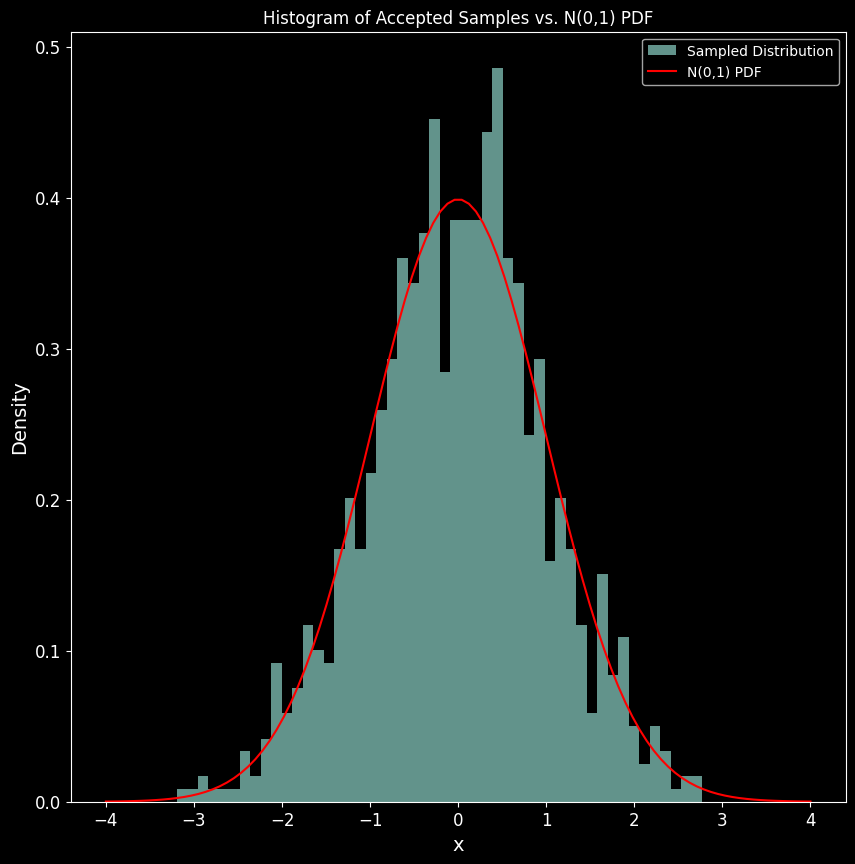

In [29]:
S = 500
n = 1000

Total_sample_needed = []
for s in range(S):
  reject = []
  xa = []
  i = 0
  while i<1001:
    k = np.sqrt(2*np.e/np.pi)
    u = np.random.uniform(0,1)
    U = np.where(u<0.5, np.log(2*u), -np.log(2-2*u))
    g = np.exp(-abs(U))/2
    f = np.exp(-U**2/2)/np.sqrt(2*np.pi)
    p = f/(k*g)
    u = np.random.uniform(0,1)
    if u <= p:
      xa.append(U)
      i+=1
    elif u > p:
      reject.append(0)
  Total_sample_needed.append(len(xa)+len(reject))

# Plot histogram of accepted samples
plt.hist(xa, bins=50, density=True, alpha=0.7, label='Sampled Distribution')
x = np.linspace(-4, 4, 100)
plt.plot(x, np.exp(-x**2 / 2) / np.sqrt(2 * np.pi), 'r-', label='N(0,1) PDF')
plt.title('Histogram of Accepted Samples vs. N(0,1) PDF')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()

In [30]:
# Construct the 95% CI
mean_sample = np.mean(Total_sample_needed)
se = np.std(Total_sample_needed, ddof=1)
print(f"The mean is {mean_sample}")
print(f"The 95% CI is {mean_sample-1.96*se},{mean_sample+1.96*se}")

The mean is 1318.058
The 95% CI is 1278.5273611831515,1357.5886388168485


Here I used 500 sample to simulate the generation of normal random variable for reaching 1000 accepted.

<hr>

**(d)** Now, suppose instead we choose the proposal distribution to be a Cauchy  distribution with pdf $g(x) = \frac{1}{\pi(1+x^2)}$. Describe and implement an inversion algorithm to get samples from this distribution, and plot the histogram of 1000 samples from this distribution.

<hr>

##### We can sample U from unif(0,1) and plug into $G^-1(u)$ which has the same distribution as g, where G is the CDF
$$
G(x) = \arctan(x)/\pi + 1/2, x \in \mathbf{R} \\
G^-1(u) = tan(\pi u - \pi/2), u \in [0,1]
$$

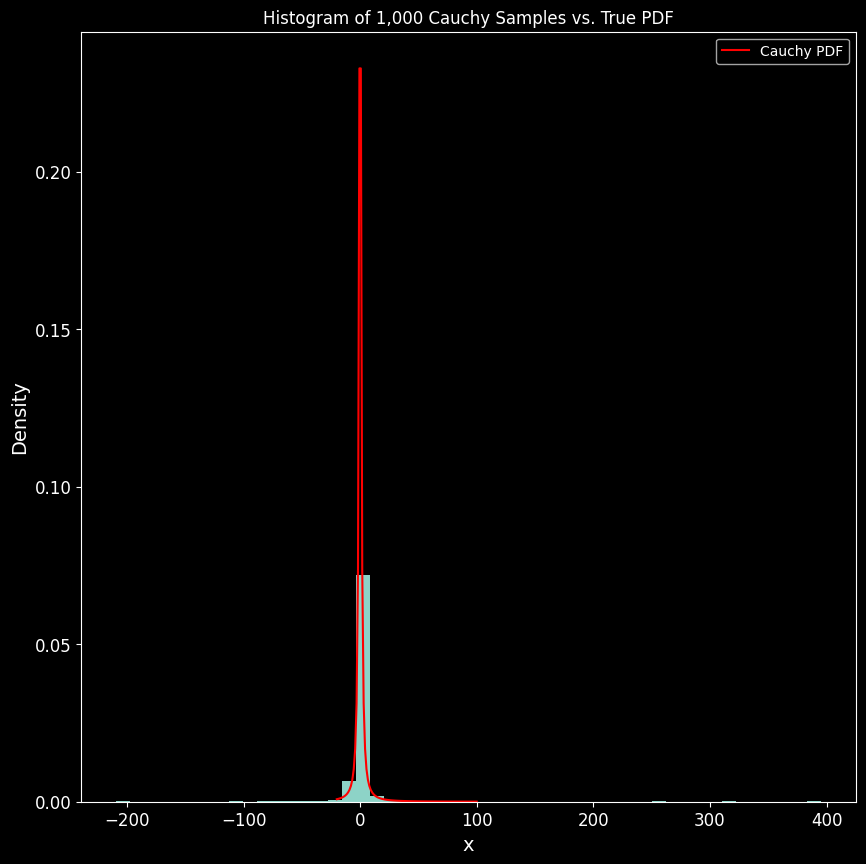

In [41]:
import numpy as np
import matplotlib.pyplot as plt

n=1000
u = np.random.uniform(0,1, n)
U = np.tan(np.pi*(u-0.5))

plt.hist(U, bins=50, density=True)
x = np.linspace(-20, 100, 100)
cauchy_pdf = 1 / (np.pi * (1 + x**2))
plt.plot(x, cauchy_pdf, 'r-', label='Cauchy PDF')
plt.title('Histogram of 1,000 Cauchy Samples vs. True PDF')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.show()

<hr>

**(e)** Repeat parts $(b)$ and $(c)$ for this proposal distribution.

<hr>

### Ans.

Define $h(x) = f(x)/g(x) = e^{-x^2/2}(g(x)/\sqrt{2\pi})$.

Maximum of $h(x)$ occurs at $x=1$ with $h(1) = \sqrt{2\pi/e} = k$. The acceptance-rejection algorithm is:

1.   Generate $U \sim G$
2.   Accept U as a sample from f(U) with probability $\frac{f(U)}{k*g(U)}$. Else, reject $U$ and return to step 1

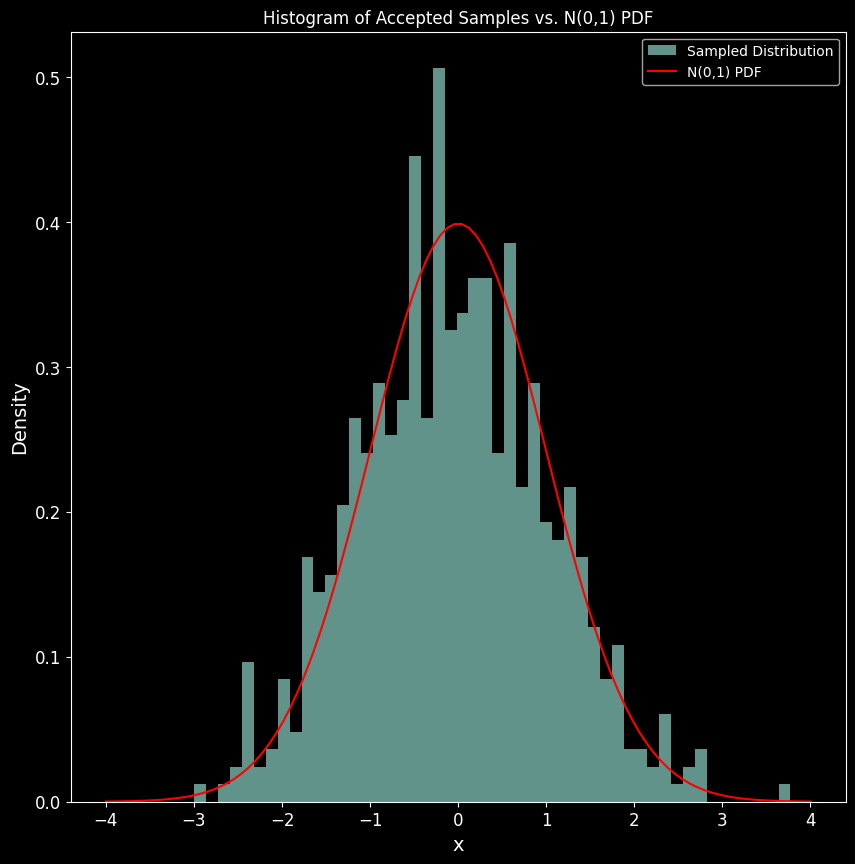

In [32]:
n = 1000
k = np.sqrt(2*np.pi/np.e)
u = np.random.uniform(0,1, n)
U = np.tan(np.pi*(u-0.5))
g = 1/(np.pi*(1+U**2))
f = np.exp(-U**2/2)/np.sqrt(2*np.pi)
p = f/(k*g)
u = np.random.uniform(0,1, n)
xa = U[u<=p]

# Plot histogram of accepted samples
plt.hist(xa, bins=50, density=True, alpha=0.7, label='Sampled Distribution')
x = np.linspace(-4, 4, 100)
plt.plot(x, np.exp(-x**2 / 2) / np.sqrt(2 * np.pi), 'r-', label='N(0,1) PDF')
plt.title('Histogram of Accepted Samples vs. N(0,1) PDF')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()

In [44]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

n_target = 1000  # Target number of accepted samples per run
k = np.sqrt(2 * np.pi / np.e)  # Correct k for Cauchy proposal ≈ 1.520
S = 100  # Number of simulation runs to estimate CI

total_proposals_per_run = []

# Run S simulations to estimate variability in total proposals needed
for s in range(S):
    accepted_samples = []
    proposals = 0
    while len(accepted_samples) < n_target:
        u = np.random.uniform(0, 1)
        U = np.tan(np.pi * (u - 0.5))
        proposals += 1
        g = 1 / (np.pi * (1 + U**2))
        f = np.exp(-U**2 / 2) / np.sqrt(2 * np.pi)
        p = f / (k * g)
        if np.random.uniform(0, 1) <= p:
            accepted_samples.append(U)
    total_proposals_per_run.append(proposals)
    # Store the last run's samples for histogram
    if s == S - 1:
        xa = np.array(accepted_samples)

# Compute mean and 95% CI for total proposals needed
mean_proposals = np.mean(total_proposals_per_run)
std_proposals = np.std(total_proposals_per_run, ddof=1)
se_proposals = std_proposals / np.sqrt(S)
ci_lower = mean_proposals - 1.96 * se_proposals
ci_upper = mean_proposals + 1.96 * se_proposals

print(f"Mean total proposals for {n_target} accepted samples (over {S} runs): {mean_proposals:.1f}")
print(f"95% CI for total proposals needed: ({ci_lower:.1f}, {ci_upper:.1f})")
print(f"Theoretical expected total proposals: {n_target * k:.1f}")
print(f"Empirical acceptance rate (average): {n_target / mean_proposals:.3f}")
print(f"Theoretical acceptance rate (1/k): {1 / k:.3f}")

Mean total proposals for 1000 accepted samples (over 100 runs): 1521.0
95% CI for total proposals needed: (1515.9, 1526.2)
Theoretical expected total proposals: 1520.3
Empirical acceptance rate (average): 0.657
Theoretical acceptance rate (1/k): 0.658


# Clarification
The homework was finished with the help of LLM AI assistant for skeleton code and topic explation.